# Autoencoders for non-supervised intrusion detection

We train the autoencoders with 'normal' traffic <br>
Then detects abnormal traffic <br>
\
\

In [41]:
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
from tensorflow import keras
from sklearn.preprocessing import normalize
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # to avoid warning messages = 3 

In [42]:
path = './data/Zero_Day/'
path_normal = path +'Normal.csv'
path_combine = path +'Combine.csv'

traffic_df = pd.read_csv(path_normal)  
combine_df = pd.read_csv(path_combine)  


In [43]:
combine_df

,R1-PA1:VH,R1-PM1:V,R1-PA2:VH,R1-PM2:V,R1-PA3:VH,R1-PM3:V,R1-PA4:IH,R1-PM4:I,R1-PA5:IH,R1-PM5:I,...,control_panel_log4,relay1_log,relay2_log,relay3_log,relay4_log,snort_log1,snort_log2,snort_log3,snort_log4,marker
0,70.399324,127673.0908,-49.572308,127648.0176,-169.578319,127723.2374,65.689611,605.91099,-57.003571,626.78553,...,0,0,0,0,0,0,0,0,0,Natural
1,73.688102,130280.7109,-46.300719,130255.6377,-166.278082,130355.9307,71.831719,483.59351,-50.947407,500.98896,...,0,0,0,0,0,0,0,0,0,Natural
2,73.733939,130305.7842,-46.254883,130280.7109,-166.232245,130381.0040,71.808800,483.59351,-50.913030,500.98896,...,0,0,0,0,0,0,0,0,0,Natural
3,74.083443,130581.5902,-45.899649,130556.5169,-165.882741,130656.8100,72.152575,482.86107,-50.437475,499.15786,...,0,0,0,0,0,0,0,0,0,Natural
4,74.553268,131083.0556,-45.424094,131057.9823,-165.424375,131158.2754,72.118198,484.50906,-50.013486,497.69298,...,0,0,0,0,0,0,0,0,0,Natural
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78372,-58.934439,130706.9565,-178.900342,130681.8832,61.094490,130782.1763,-60.149109,444.59108,178.808669,449.90127,...,0,0,0,0,0,0,0,0,0,Natural
78373,-59.020382,131057.9823,-178.992015,131032.9090,61.002816,131108.1288,-61.507019,451.73237,177.857559,454.66213,...,0,0,0,0,0,0,0,0,0,Natural
78374,-59.031842,131083.0556,-179.003474,131032.9090,60.997087,131133.2021,-61.535667,451.91548,177.857559,454.66213,...,0,0,0,0,0,0,0,0,0,Natural
78375,-59.077678,131108.1288,-179.049311,131057.9823,60.951250,131158.2754,-61.839335,453.38036,177.725778,455.02835,...,0,0,0,0,0,0,0,0,0,Natural


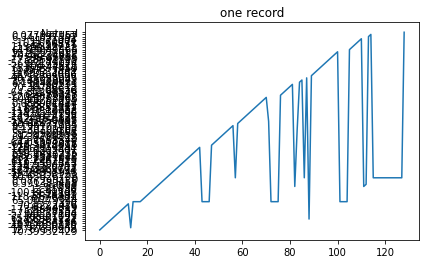

In [31]:
y = traffic_df.iloc[[0]].values.tolist() 
x = list(range(0, len(y[0])))
fig = plt.figure()
plt.plot(x,y[0])
plt.title('one record')
plt.show()

In [32]:
traffic_df.columns

Index(['R1-PA1:VH', 'R1-PM1:V', 'R1-PA2:VH', 'R1-PM2:V', 'R1-PA3:VH',
       'R1-PM3:V', 'R1-PA4:IH', 'R1-PM4:I', 'R1-PA5:IH', 'R1-PM5:I',
       ...
       'control_panel_log4', 'relay1_log', 'relay2_log', 'relay3_log',
       'relay4_log', 'snort_log1', 'snort_log2', 'snort_log3', 'snort_log4',
       'marker'],
      dtype='object', length=129)

In [33]:
# Delete marker column in dataframe as it is not numeric < check with darshana >
traffic_df.drop(['marker'], axis=1, inplace=True)
combine_df.drop(['marker'], axis=1, inplace=True)

In [34]:
# each row of the dataframe is considered a sequence
# we create a numpy array with the sequences
traffic_np = traffic_df.to_numpy()
print('normal shape',traffic_np.shape)
combine_np = combine_df.to_numpy()
print('test shape', combine_np.shape)

normal shape (22714, 128)
test shape (78377, 128)


In [35]:
# This is how it looks
traffic_np

array([[ 7.03993243e+01,  1.27673091e+05, -4.95723084e+01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 7.36881020e+01,  1.30280711e+05, -4.63007194e+01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 7.37339387e+01,  1.30305784e+05, -4.62548828e+01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [-5.90318416e+01,  1.31083056e+05, -1.79003474e+02, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-5.90776783e+01,  1.31108129e+05, -1.79049311e+02, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-5.92037290e+01,  1.31158275e+05, -1.79169632e+02, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

In [37]:
# manage NaNs & inf
print('normal traffic NaNs', np.count_nonzero(np.isnan(traffic_np)))
print('normal traffic inf', np.count_nonzero(np.isinf(traffic_np)))
print('combine traffic NaNs', np.count_nonzero(np.isnan(combine_np)))
print('combine traffic inf', np.count_nonzero(np.isinf(combine_np)))
traffic_np = np.nan_to_num(traffic_np, copy=False, nan=0.0, posinf=0.0, neginf=0.0)
combine_np = np.nan_to_num(combine_np, copy=False, nan=0.0, posinf=0.0, neginf=0.0)
# not so sure that inf is correctly set to 0

normal traffic NaNs 0
normal traffic inf 0
combine traffic NaNs 0
combine traffic inf 0


In [38]:
# normalize the data on each column
# Normalize and save the mean and std we get,
# for normalizing test data.

traffic_np_norm = normalize(traffic_np, axis=0, norm='max')
combine_np_norm = normalize(combine_np, axis=0, norm='max')

In [39]:
x_train = traffic_np_norm[...,np.newaxis]
x_combine = combine_np_norm[...,np.newaxis]
print("Normal Traffic Training input shape: ", x_train.shape)
print("Combine Traffic Test input shape: ", x_combine.shape)

Normal Traffic Training input shape:  (22714, 128, 1)
Combine Traffic Test input shape:  (78377, 128, 1)


In [22]:
def build_model():
    input_a = layers.Input(shape=(x_train.shape[1], x_train.shape[2]))
    x = layers.Conv1D(filters=32, kernel_size=7, padding="same", strides=2, activation="relu")(input_a)
    x = layers.Dropout(rate=0.2)(x)
    x = layers.Conv1D(filters=16, kernel_size=7, padding="same", strides=2, activation="relu")(x)
    x = layers.Conv1DTranspose(filters=16, kernel_size=7, padding="same", strides=2, activation="relu")(x)
    x = layers.Dropout(rate=0.2)(x)
    x = layers.Conv1DTranspose(filters=32, kernel_size=7, padding="same", strides=2, activation="relu")(x)
    output = layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same")(x)
    
    model = keras.Model(inputs=[input_a], outputs=output)
    
    return model

keras.backend.clear_session()

model = build_model()
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 64, 32)            256       
                                                                 
 dropout (Dropout)           (None, 64, 32)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 32, 16)            3600      
                                                                 
 conv1d_transpose (Conv1DTra  (None, 64, 16)           1808      
 nspose)                                                         
                                                                 
 dropout_1 (Dropout)         (None, 64, 16)            0         
                                                             

In [23]:
## Train the model

#Please note that we are using `x_train` as both the input and the target
#since this is a reconstruction model.
#"""

history = model.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

Epoch 1/50
160/160 [==============================] - 3s 14ms/step - loss: 0.0671 - val_loss: 0.0041
Epoch 2/50
160/160 [==============================] - 2s 12ms/step - loss: 0.0181 - val_loss: 0.0024
Epoch 3/50
160/160 [==============================] - 2s 12ms/step - loss: 0.0142 - val_loss: 0.0024
Epoch 4/50
160/160 [==============================] - 2s 12ms/step - loss: 0.0117 - val_loss: 0.0029
Epoch 5/50
160/160 [==============================] - 2s 12ms/step - loss: 0.0098 - val_loss: 0.0031
Epoch 6/50
160/160 [==============================] - 2s 12ms/step - loss: 0.0085 - val_loss: 0.0037
Epoch 7/50
160/160 [==============================] - 2s 12ms/step - loss: 0.0077 - val_loss: 0.0038


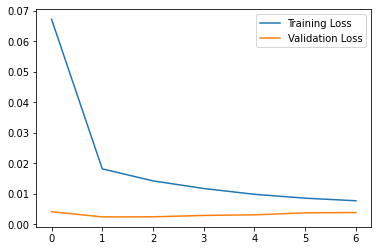

In [24]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

In [ ]:
### Test the results
## use label 

# Get test MAE loss.
x_test_pred = model.predict(x_combine)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))

# Detect all the samples which are anomalies.
anomalies = test_mae_loss > threshold
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))
